In [2]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.cluster import KMeans
import pickle
import seaborn as sns
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


Populating the interactive namespace from numpy and matplotlib


In [3]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог за последний год
sql_query = "SELECT  \
      [PartnerID] \
      ,[Age] \
      ,[SEX] \
      ,[CityID] \
      ,LifeTimeM*30/QntPurchaseCode AvgDneyPrihodov \
      ,[LifeTimeM] + DATEDIFF(Month, PurchaseDateTime, GetDate()) [LifeTimeM] \
      ,[QntPurchaseCode] \
      ,[SumQuantity] \
      ,[SUMisPartnerPromotionID] \
      ,[PercentisPartnerPromotionID] \
      ,[AVGisPartnerPromotionID] \
      ,[SUMisCrossPromo] \
      ,[PercentisCrossPromo] \
      ,[AVGisCrossPromo] \
      ,[PercentSMS_new] \
      ,[AVGPercentinSMS] \
      ,[PercentMonth1] \
      ,[PercentMonth2] \
      ,[PercentMonth3] \
      ,[PercentMonth4] \
      ,[PercentMonth5] \
      ,[PercentMonth6] \
      ,[PercentMonth7] \
      ,[PercentMonth8] \
      ,[PercentMonth9] \
      ,[PercentMonth10] \
      ,[PercentMonth11] \
      ,[PercentMonth12] \
      ,[PercentNY] \
      ,[PercentDR] \
      ,[PercentVD] \
      ,[Percent8M] \
      ,[SUMPrice] \
      ,[AVGPrice] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SumSummaDiscount] \
      ,[AvgSummaDiscount] \
      ,[AVGProcentSkidki] \
      ,[PercentMen] \
      ,[SumChild] \
      ,[PercentChild] \
      ,[PercentKolco] \
      ,[PercentSERGI] \
      ,[PercentPODVES] \
      ,[PercentFUTLAR] \
      ,[PercentCEP] \
      ,[PercentBRASLET] \
      ,[PercentKOLE] \
      ,[PercentNKNOWN_WEAR] \
      ,[AVGCostPrice] \
      ,[AVGCostMin] \
      ,[AVGCostTag] \
      ,[AVGCostStock] \
      ,[AVGCostRetail] \
      ,[AVGGiftCardPositionID] \
      ,[SumGiftCardPositionID] \
      ,[AVGQntName] \
      ,[PercentExpensive] \
      ,[PercentCheap] \
      ,[PercentPremium] \
      ,[PercentMidle] \
      ,[PercentGold] \
      ,[PercentSilver] \
      ,[PercentNoMetal] \
  FROM [Gold585].[dbo].[RetailCommon] a \
  WHERE partnerID <> 0 and PurchaseDateTime = (Select MAX(PurchaseDateTime) MaxDate From RetailCommon rt where rt.PartnerID = a.PartnerID) \
  and PurchaseDateTime >= CAST('2015-01-01' as DATE) \
  order BY PartnerID, PurchaseDateTime"
data = pd.read_sql(sql_query,conn)

In [4]:
data.head()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,AVGGiftCardPositionID,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal
0,2,46,0,35,0,32,1,2.0,0,0,...,0,0,1,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
1,4,118,0,92,75,21,8,12.0,0,0,...,0,0,1,0.25,0.5,0.0,0.25,0.0,0.916667,0.0
2,6,30,0,32,0,32,1,2.0,0,0,...,0,0,2,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
3,9,116,0,122,0,32,1,1.0,0,0,...,0,0,1,1.00,0.0,0.0,0.00,1.0,0.000000,0.0
4,10,20,0,105,0,32,1,2.0,0,0,...,0,0,2,0.00,1.0,0.0,0.00,0.0,0.500000,0.5


In [5]:
data[data['PartnerID']==3864477]

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,AVGGiftCardPositionID,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal
1381516,3864477,39,0,46,78,15,5,9.0,0,0,...,0,0,1,0.111111,0.444444,0.0,0.444444,0.111111,0.777778,0.0


In [6]:
print(np.percentile(data['SumSumma'],99)) # у 99 процентов посетителей < 10 покупок

80172.0


In [7]:
data[data['SumSumma']>84387.95999999996].PartnerID.count()

22658

In [8]:
print(np.percentile(data['QntPurchaseCode'],99)) # у 99 процентов посетителей < 10 покупок

10.0


In [9]:
data[data['QntPurchaseCode']>10].PartnerID.count()

20953

In [10]:
target.columns.values

NameError: name 'target' is not defined

In [76]:
target[((target['PercentSMS_new']!=0) &(target['PercentSMS_new']!=1))].head()

,Age,SEX,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,PercentisPartnerPromotionID,PercentisCrossPromo,PercentSMS_new,AVGPercentinSMS,SumSumma,AVGSumma,AVGProcentSkidki,PercentKolco,PercentSERGI,PercentPODVES,PercentCEP,PercentBRASLET,PercentGold,PercentSilver
0,69,0,62,32,11,0,0.363636,0.090909,0.500,35992.0,3272.0000,0.4204,0.250000,0.416667,0.083333,0.083333,0.083333,0.416667,0.500000
1,25,1,52,33,15,0,0.000000,0.066667,0.500,57014.0,3800.9333,0.4759,0.192308,0.153846,0.153846,0.153846,0.115385,0.461538,0.307692
2,42,0,57,30,14,0,0.000000,0.071429,0.500,25280.0,1805.7142,0.4696,0.312500,0.437500,0.125000,0.062500,0.000000,0.875000,0.062500
5,34,1,65,32,12,0,0.000000,0.166667,0.425,154907.0,12908.9166,0.4173,0.181818,0.454545,0.090909,0.136364,0.090909,0.909091,0.045455
7,21,0,40,32,17,1,0.000000,0.352941,0.400,21740.0,1278.8235,0.3176,0.192308,0.384615,0.000000,0.057692,0.076923,0.038462,0.250000


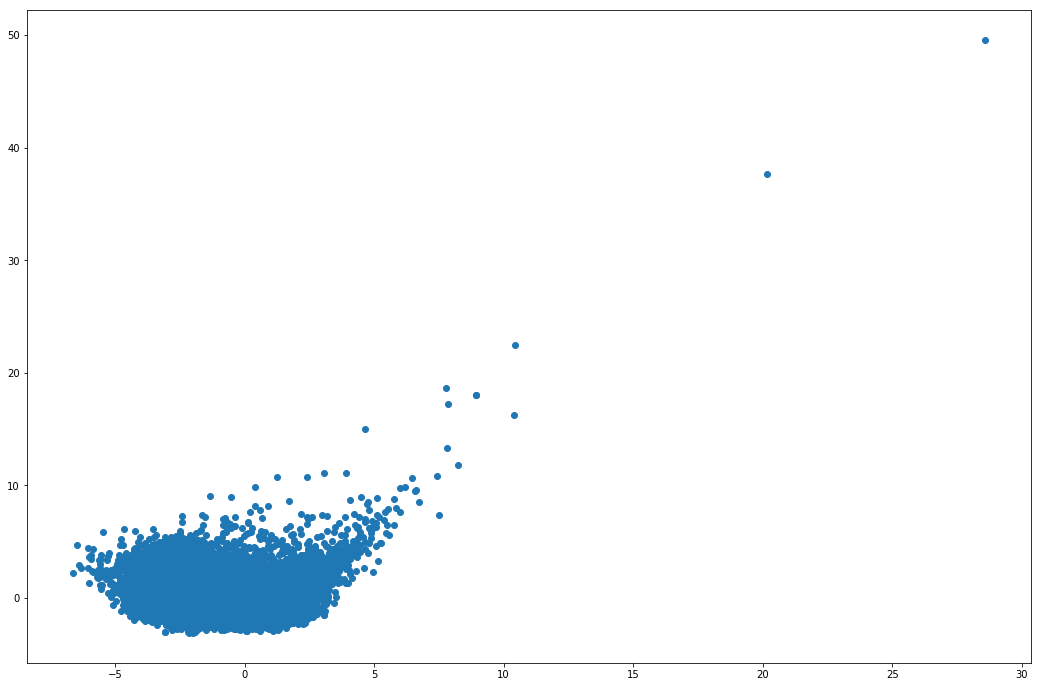

In [11]:
df = data[ (data['QntPurchaseCode']>10) ].fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild'\
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target = pd.get_dummies(target, columns = ['CityID'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [12]:
print(datetime.datetime.now())

2018-09-19 14:37:54.831598


Wall time: 7.04 s


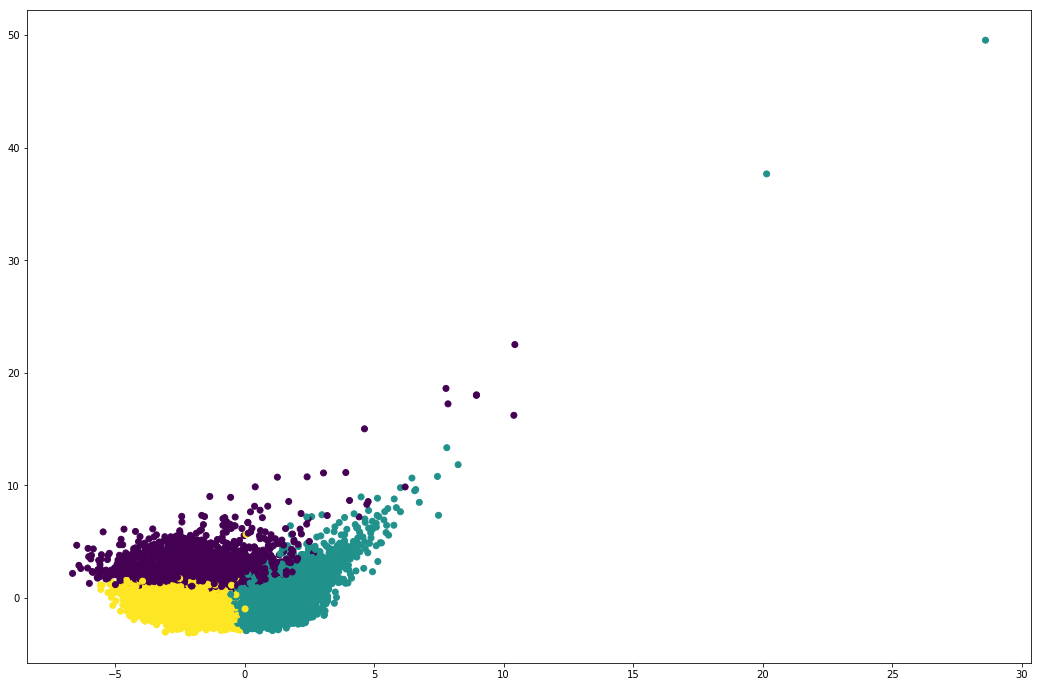

In [14]:
%%time
#Для 1%, где больше 10 покупок
kmeans = KMeans(n_clusters= 3, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [15]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
#print(df[df['labels']==3].shape[0])
#print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

20953
1944
12429
6580


In [16]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
 #          df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
 #          df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
 #          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('3.csv')

2018-09-14 11:10:36.596953


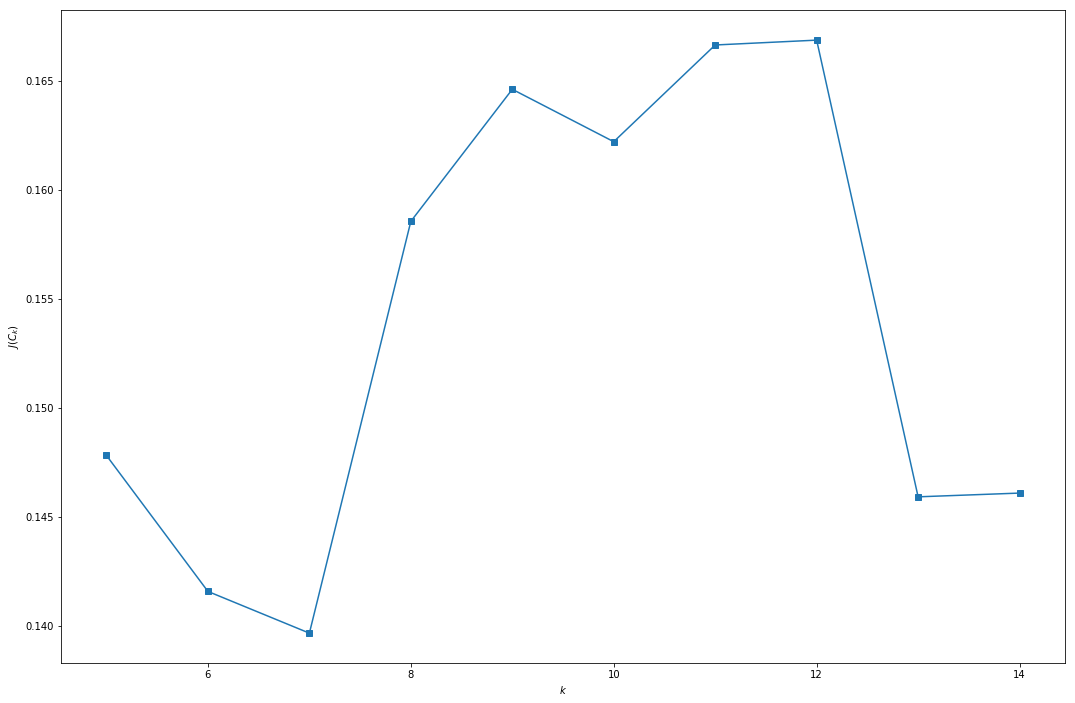

In [29]:

plt.plot(range(5, 15), mas1, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
print(datetime.datetime.now())

In [85]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return np.mean(sil_samples)

2018-09-14 18:09:29.948851
0.1675618314938049
0.1585351920807593
0.12212918833803779
0.12477803386294978
0.10887686478704445
0.10306984078768335
0.10357096476896842
0.1094357619825263
0.11358236821815376
Wall time: 2min 14s


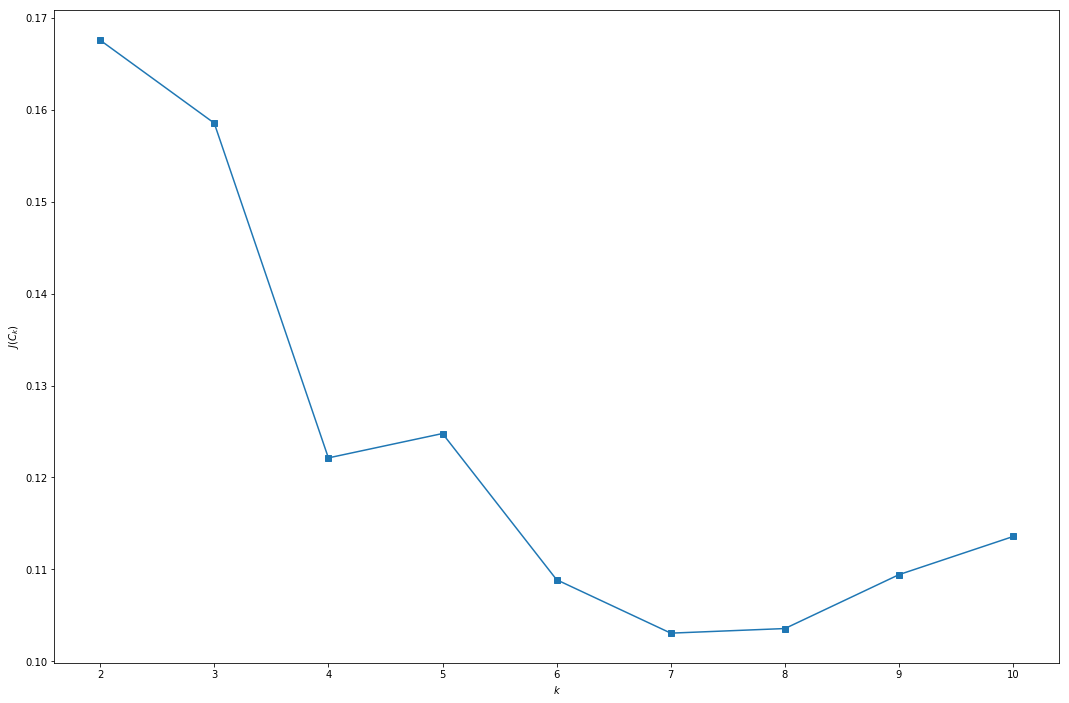

In [91]:
%%time
now = datetime.datetime.now()
print(now)
X1 = pd.DataFrame(X) #.sample(100000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
mas1 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    a1= silhouette_samples_memory_saving(X1, kmeans.labels_)
    #a= silhouette_score(X1, kmeans.labels_)
    #mas.append(a)
    mas1.append(a1)
    print(a1)

plt.plot(range(2, 11), mas1, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
# Оптимальное количество кластеров, для 1 %   кластера 3 bkb 5

2018-09-14 17:24:20.746620
0.11015836734027602
0.09468421111020266
0.1215131630641314
0.11117545547565515
0.10169386293519803
0.10315351843431128
0.10708502872679768
Wall time: 23min 38s


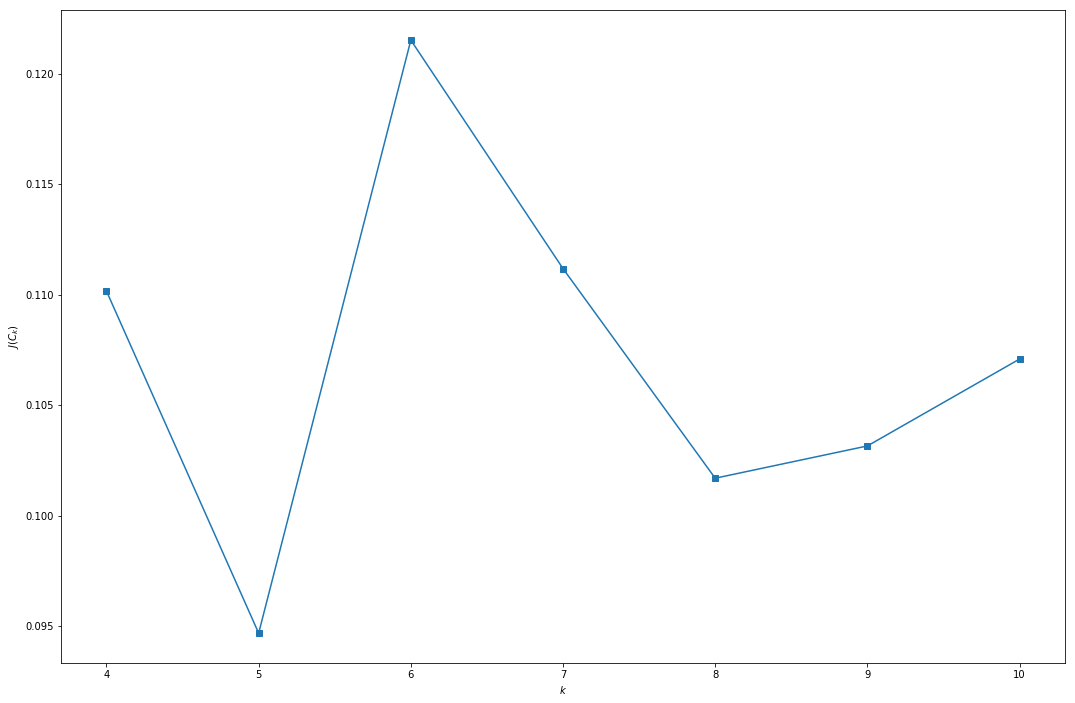

In [86]:
%%time
now = datetime.datetime.now()
print(now)
X1 = pd.DataFrame(X).sample(100000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
mas1 = []
for k in range(4, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    a1= silhouette_samples_memory_saving(X1, kmeans.labels_)
    #a= silhouette_score(X1, kmeans.labels_)
    #mas.append(a)
    mas1.append(a1)
    print(a1)

plt.plot(range(4, 11), mas1, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
# Оптимальное количество кластеров, для 99 % 6 кластера

Wall time: 56.2 s


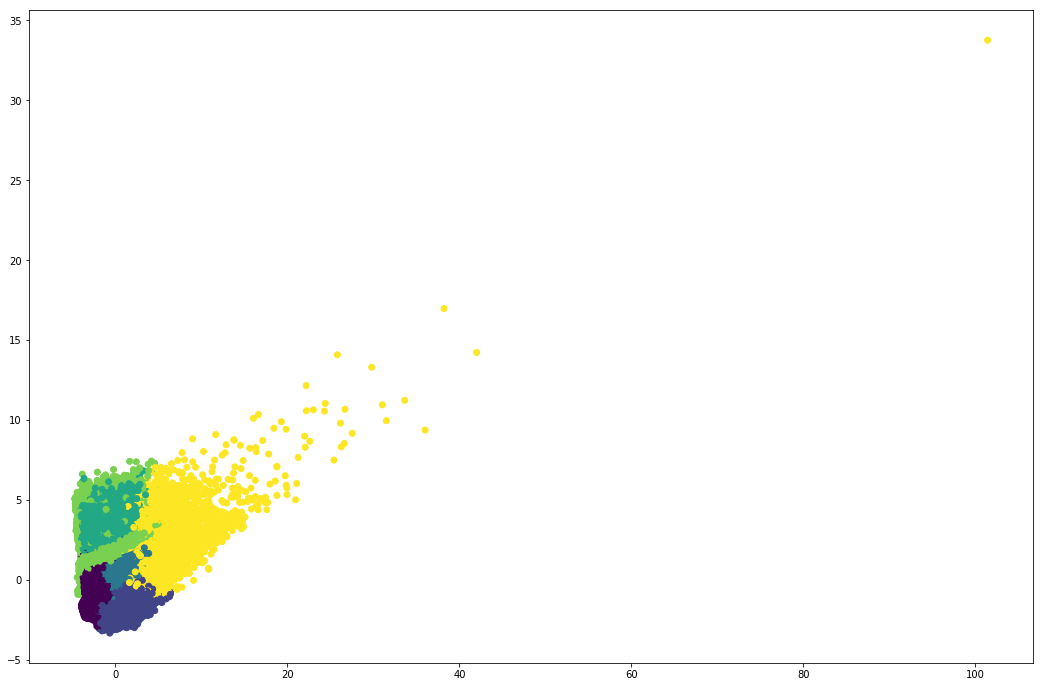

In [87]:
%%time
kmeans = KMeans(n_clusters= 6, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [78]:
df.tail()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal,labels
27058,6327014,28,0,7,5,2,12,23.0,0,0,...,0,1,0.521739,0.173913,0.0,0.304348,0.260870,0.695652,0.000000,0
27059,6336680,39,1,92,2,2,12,50.0,0,0,...,0,3,0.440000,0.180000,0.0,0.380000,0.900000,0.040000,0.000000,0
27060,6378000,36,0,61,4,2,13,37.0,10,1,...,0,1,0.054054,0.297297,0.0,0.648649,0.432432,0.378378,0.189189,0
27061,6404172,44,0,35,3,1,10,47.0,1,0,...,0,4,0.340426,0.255319,0.0,0.404255,0.659574,0.340426,0.000000,0
27062,6411315,35,0,78,2,1,11,31.0,0,0,...,0,2,0.129032,0.451613,0.0,0.419355,0.451613,0.419355,0.000000,0


In [79]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
#print(df[df['labels']==3].shape[0])
#print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

27063
2713
15864
8486


In [88]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

930199
233562
128660
288754
156579
35460
87184


In [89]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
           df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('2 Client-last-Purch AVG-from 2015-more2Purch-99 6 kl.csv')

In [129]:
#Клиенты с 1 покпкой

4

In [20]:
df[df['labels']==4]

,PurchaseCode,PartnerID,Sex,Age,QntPurchaseCode,SUMisPartnerPromotionID,SUMisCrossPromo,SUMSMS30,SUMSMS14,SumQuantity,...,AVGIsMidle,SumIsUnknownLevel,AVGIsUnknownLevel,SumIsGold,AVGIsGold,SumIsSilver,AVGIsSilver,SumIsNoMetal,AVGIsNoMetal,labels
982396,1202847493,2377429,0.0,0,409,0,0,399,399,9.0,...,5,0,0,3415,8,2414,5,1,0,4
1022005,1198824994,5319346,0.0,67,542,542,0,445,444,4.0,...,4,0,0,2901,5,2723,5,0,0,4
1114227,1201040800,5283999,1.0,51,294,281,0,274,265,32.0,...,4,0,0,1354,4,1397,4,306,1,4
1292769,1212129462,1494590,0.0,36,131,66,22,48,45,16.0,...,18,0,0,2411,18,2514,19,48,0,4
1499811,1217186965,5339367,1.0,37,117,114,0,116,103,1.0,...,14,0,0,2456,20,1561,13,167,1,4
